In [33]:
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


## Load the data

In [11]:
# Load data from pickle file 
with open('dictionary.pkl', 'rb') as f:
    dictionary = pickle.load(f)

with open('preprocessed_docs.pkl', 'rb') as f:
    docs = pickle.load(f)

In [12]:
docs

[[29,
  20,
  11,
  30,
  17,
  5,
  21,
  31,
  9,
  6,
  27,
  15,
  14,
  7,
  4,
  6,
  25,
  0,
  3,
  24,
  23,
  1,
  13,
  18,
  8,
  26,
  32,
  22,
  10,
  12,
  15,
  16,
  28,
  2,
  19],
 [42,
  77,
  43,
  62,
  50,
  74,
  50,
  43,
  65,
  56,
  33,
  43,
  75,
  36,
  69,
  30,
  77,
  20,
  11,
  42,
  77,
  49,
  60,
  39,
  71,
  75,
  43,
  61,
  68,
  48,
  62,
  67,
  40,
  58,
  45,
  48,
  63,
  72,
  37,
  64,
  72,
  41,
  34,
  54,
  70,
  55,
  76,
  51,
  46,
  52,
  51,
  47,
  66,
  73,
  44,
  59,
  57,
  38,
  43,
  75,
  53,
  35,
  62,
  28,
  77],
 [133,
  151,
  156,
  134,
  133,
  30,
  8,
  59,
  93,
  101,
  127,
  50,
  103,
  102,
  155,
  145,
  114,
  117,
  116,
  144,
  111,
  15,
  125,
  128,
  118,
  86,
  134,
  109,
  143,
  35,
  82,
  13,
  91,
  139,
  128,
  112,
  98,
  107,
  148,
  84,
  147,
  53,
  107,
  83,
  78,
  31,
  82,
  12,
  82,
  107,
  140,
  130,
  94,
  128,
  115,
  121,
  104,
  138,
  110,
  92,
  131,
  149

In [45]:
def lda(data, dictionary, iterations = 100, topics = 20, alpha = 0.01, gamma = 0.01):
    """
    data: list of preprocessed documents
    dictionary: gensim.corpora.Dictionary object
    Plot the distribution over topics for the longest document in the data after
    initialization and after 1st, 2nd, 5th, 10th, 20th, 50th, and 100th iteration.
    Comment on these. (
    """
    plot_iters = [1, 2, 5, 10, 20, 50, 100]

    # Longest document index in data
    longest_doc = np.argmax([len(doc) for doc in data])

    doc_cnt = len(data)
    word_cnt = len(dictionary)

    z = []
    # Init z_nd randomly
    for d in range(doc_cnt):
        N_d = len(data[d])
        z_nd = np.random.randint(0, topics, N_d)
        z.append(z_nd)

    # Compute cd_dk and cw_mk and c_k 
    cd_dk = np.zeros((doc_cnt, topics))
    cw_mk = np.zeros((word_cnt, topics))
    c_k = np.zeros(topics)

    # Compute cd_dk
    for d in range(doc_cnt):
        for k in range(topics):
            cd_dk[d, k] = np.sum(z[d] == k)
          
    # Compute cw_mk and c_k
    for m in range(word_cnt):
        for k in range(topics):
            cw_mk[m, k] = np.sum(z[:][m] == k)
            c_k[k] = np.sum(cw_mk[:][k])

    for i in range(1, iterations + 1):
        for d in range(doc_cnt):
            N_d = len(data[d])
            for n in range(0, N_d):
                znd = z[d][n]
                cd_dk[d, znd] -= 1
                cw_mk[m, znd] -= 1
                c_k[znd] -= 1

                p = np.zeros(topics)
                w_nd = data[d][n] 
                for k in range(topics):
                    p[k] =  (alpha + cd_dk[d, k]) * (gamma + cw_mk[w_nd, k]) / ((word_cnt * gamma + c_k[k]) * (topics * alpha + N_d - 1))
                # Normalize p
                p = p / np.sum(p)

                # Sample k from probability distribution p
                k = np.random.choice(topics, p = p)
                z[d][n] = k

                cd_dk[d, k] += 1
                cw_mk[w_nd, k] += 1
                c_k[k] += 1
        
        # Plot distribution over topics for longest document
        if i in plot_iters:
            count_k = np.zeros(topics)
            for k in range(topics):
                count_k[k] = np.sum(z[longest_doc] == k)
            plt.bar(np.arange(topics), count_k)
            plt.xlabel('Topic')
            plt.ylabel('Count')
            plt.title('Iteration ' + str(i))
            plt.show()
            
    return cd_dk, cw_mk, c_k, z_nd
                


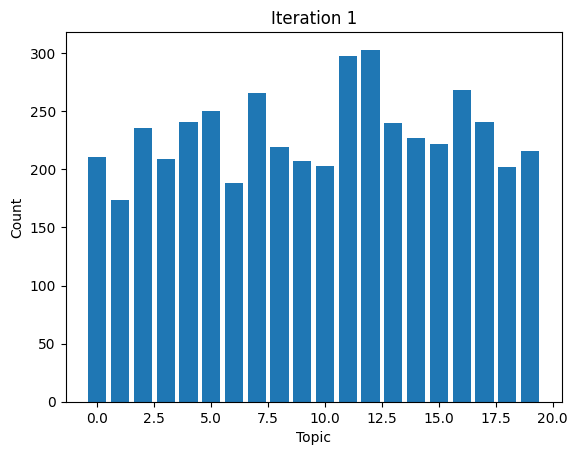

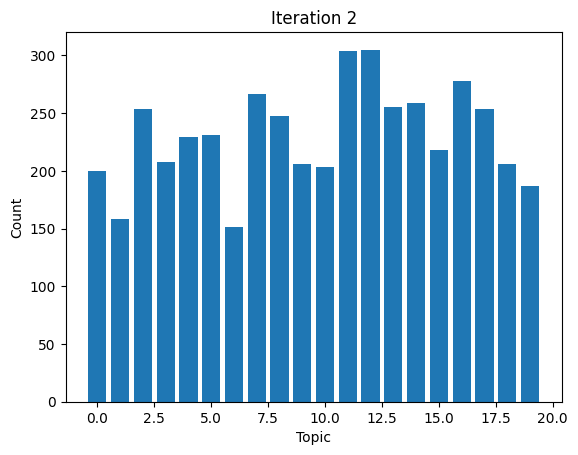

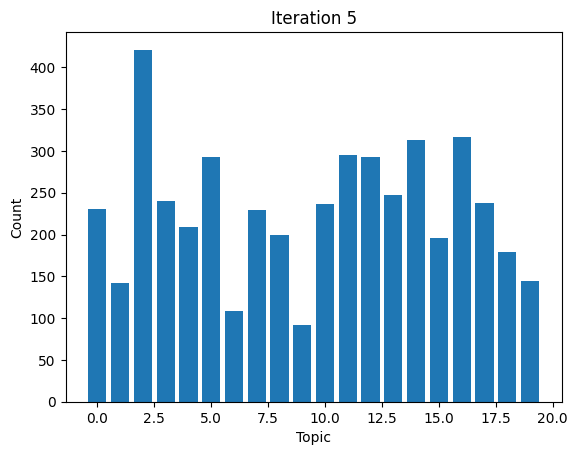

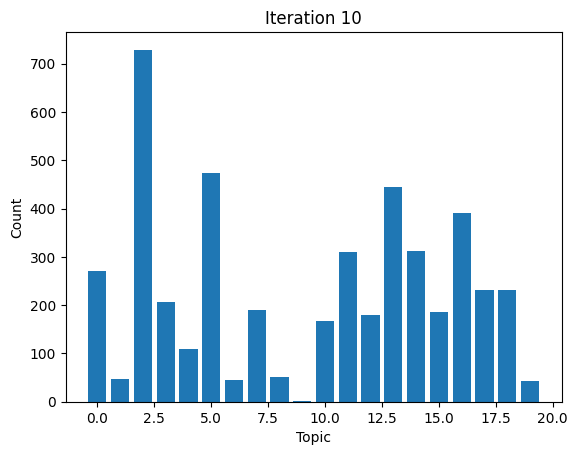

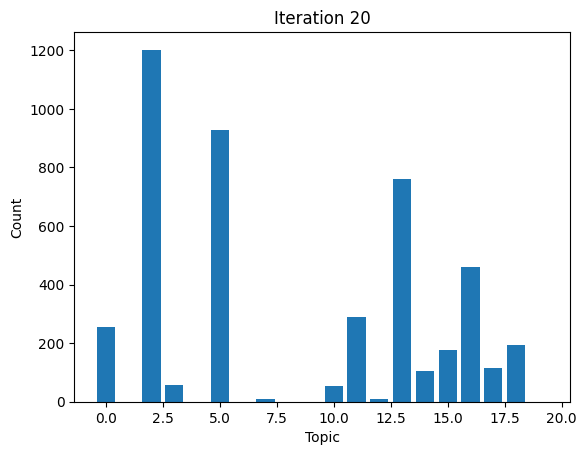

In [46]:
lda(docs, dictionary)

/tmp/u/hovsepym/ipykernel_11105/915676834.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, hist = False, kde = True,
/afs/ms.mff.cuni.cz/u/h/hovsepym/Desktop/Semester_5/UnsupMLInNLP/unsuo/lib/python3.11/site-packages/seaborn/distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


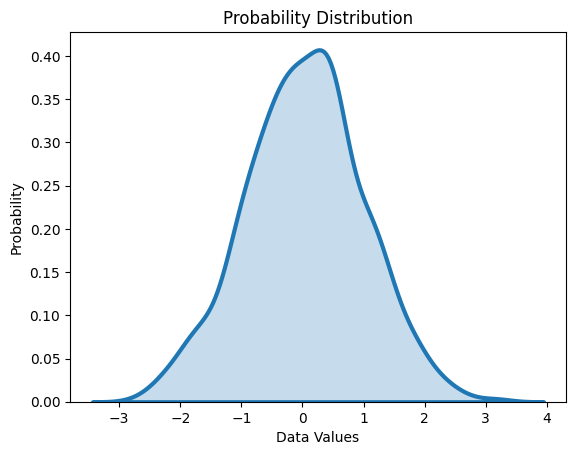

In [32]:
# Python

# Generate random data
data = np.random.normal(size=1000)

# Create a seaborn distplot
sns.distplot(data, hist = False, kde = True, 
             kde_kws = {'shade': True, 'linewidth': 3})

plt.xlabel('Data Values')
plt.ylabel('Probability')
plt.title('Probability Distribution')

plt.show()

In [31]:
pip install seaborn

  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/7b/e5/83fcd7e9db036c179e0352bfcd20f81d728197a16f883e7b90307a88e65e/seaborn-0.13.0-py3-none-any.whl.metadata
  Using cached seaborn-0.13.0-py3-none-any.whl.metadata (5.3 kB)
Using cached seaborn-0.13.0-py3-none-any.whl (294 kB)

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
